# PyCPT Seasonal

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).


#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.


### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work = 'Final_Test3'

########Some folder and file options:
# Where do you want to make the work folder-- this should already exist!!! 
workdir = "/Users/kylehall/Projects/PYCPT/Test/PyCPT-Dev"
# PATH to CPT directory (folder containing CPT.x (Mac / Unix) or CPT_Batch.exe (Windows))
cptdir='/Users/kylehall/CPT/16.5.8/'
shp_file = 'None'# '/Users/kylehall/Projects/PyCPT/PyCPT-Dev/local/sascof_boundary_final.shp' #path from pycpt_functions_seasonal.py to your shape file
use_default = 'True' #Make False to turn off default country boundaries

########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']

#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=['Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='ENACTS-BD'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA' 


#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5
eofmodes = 3 #number of EOF modes to compute

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=[ 'May', 'Sep']
tgti=['1.5', '1.5']  #S: start for the DL
tgtf=['4.5', '3.5']   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Jun-Sep', 'Oct-Dec']

tini = 1982
tend = 2009

########Forecast date  
monf=['May', 'Sep'] 	# Initialization month 
fyr=2019 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude


#If you have local observations data, please provide some metadata here!
local_obs_files = ['none', 'none'] #['../local/Merged_data_OND_1982_2019.tsv', '../local/MERGED_DATA_JJAS_1982_2019.tsv']#['../MERGED_DATA_S_ASIA_1982_2019_JJAS.nc','../Merged_data_yrmean_OND_1982_2019.nc'] #either 'None' if you don't have local data, or the path of your local obs data file
local_obs_LongitudeKey = 'LONGITUDE' #ncdf key for accessing latitude - must be the same for all files
local_obs_LatitudeKey = 'LATITUDE'   #ncdf key for accessing longitude
local_obs_timeKey = 'time'           #ncdf key for accessing time
local_obs_datakey = 'rf'             #ncdf key for accessing data itself


### End of namelist section 

#### Load Libraries

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform


pycpt = PyCPT_Args(workdir, work, cptdir, models, met, obs, station, MOS, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, eofmodes, PREDICTAND, PREDICTOR, mons, tgti, tgtf, tgts, tini, tend, monf, fyr, force_download, nla1, sla1, wlo1, elo1, nla2, sla2, wlo2, elo2, local_obs_files, local_obs_LongitudeKey, local_obs_LatitudeKey, local_obs_timeKey, local_obs_datakey, shp_file, use_default)
setup_directories(work, workdir, force_download, cptdir)


mkdir: scripts: File exists
mkdir: images: File exists
mkdir: input: File exists
mkdir: output: File exists


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

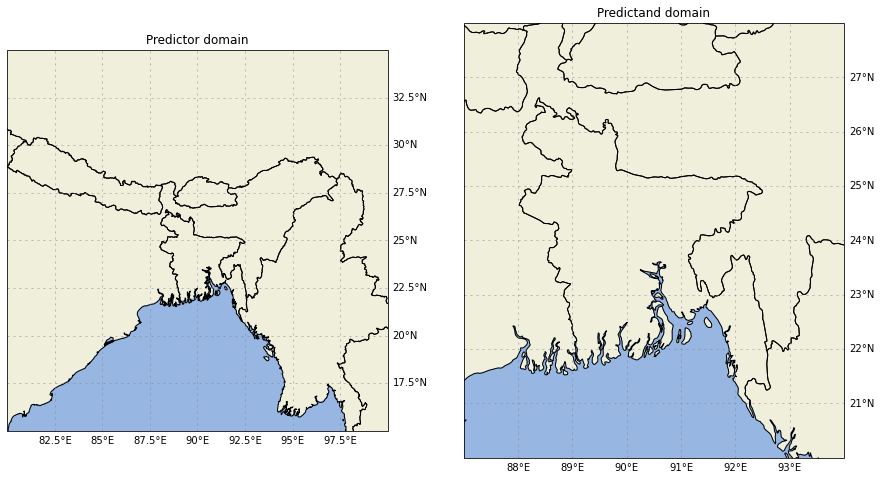

In [3]:
#Plot domains
pycpt.pltdomain()

# Download data if necessary, and run CPT

In [4]:

#If downloadling data from several models, this section might take a while to be done
for model in range(len(models)):
    print('\n\n\n--------Starting process for '+models[model]+'--------')
    for tgt in range(len(mons)):
    
        ########Set Up Useful Variables Automatically - tini & tend may change based on tgt
        pycpt.setupParams(tgt)
            
        #download input files for CPT
        pycpt.prepFiles(tgt, model)
        
        #write CPT input script automatically
        pycpt.CPTscript(tgt, model)
        
        #run CPT
        pycpt.run(tgt, model)
        




--------Starting process for COLA-RSMAS-CCSM4--------
Predictand is Rainfall Total (mm)
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Hindcasts precip file doesn't exist --SOLVING: downloading file

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  180k  100  180k    0     0   599k      0 --:--:-- --:--:-- --:--:--  597k
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/4/mul/T/%28Jan%201982%29/%28Dec%

100  180k  100  180k    0     0   578k      0 --:--:-- --:--:-- --:--:--  576k
Hindcasts file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/3/mul/T/%28Jan%201982%29/%28Dec%202010%29/RANGE/T/%28Oct-Dec%29/seasonalAverage/Y/%2820%29/%2828%29/RANGEEDGES/X/%2887%29/%2894%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
curl -k https://datalibrary.bmd.gov.bd/SOURCES/.Bangladesh/.BMD/.monthly/.rainfall/.rfe_merged/3/mul/T/%28Jan%201982%29/%28Dec%202010%29/RANGE/T/%28Oct-Dec%29/seasonalAverage/Y/%2820%29/%2828%29/RANGEEDGES/X/%2887%29/%2894%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv > ./input/obs_PRCP_Oct-Dec.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5791k  100 5791k    0     0   315k      0  0:00:18  0:00:18 --:-

## Deterministic Skill Analysis

In [3]:
# Skill scores loop
for ime in range(len(met)):
    pycpt.pltmap(ime)   


Predictand is Rainfall Total (mm)


##### EOF Analysis (only available if MOS=PCR or CCA)




-------------EOF 1-------------



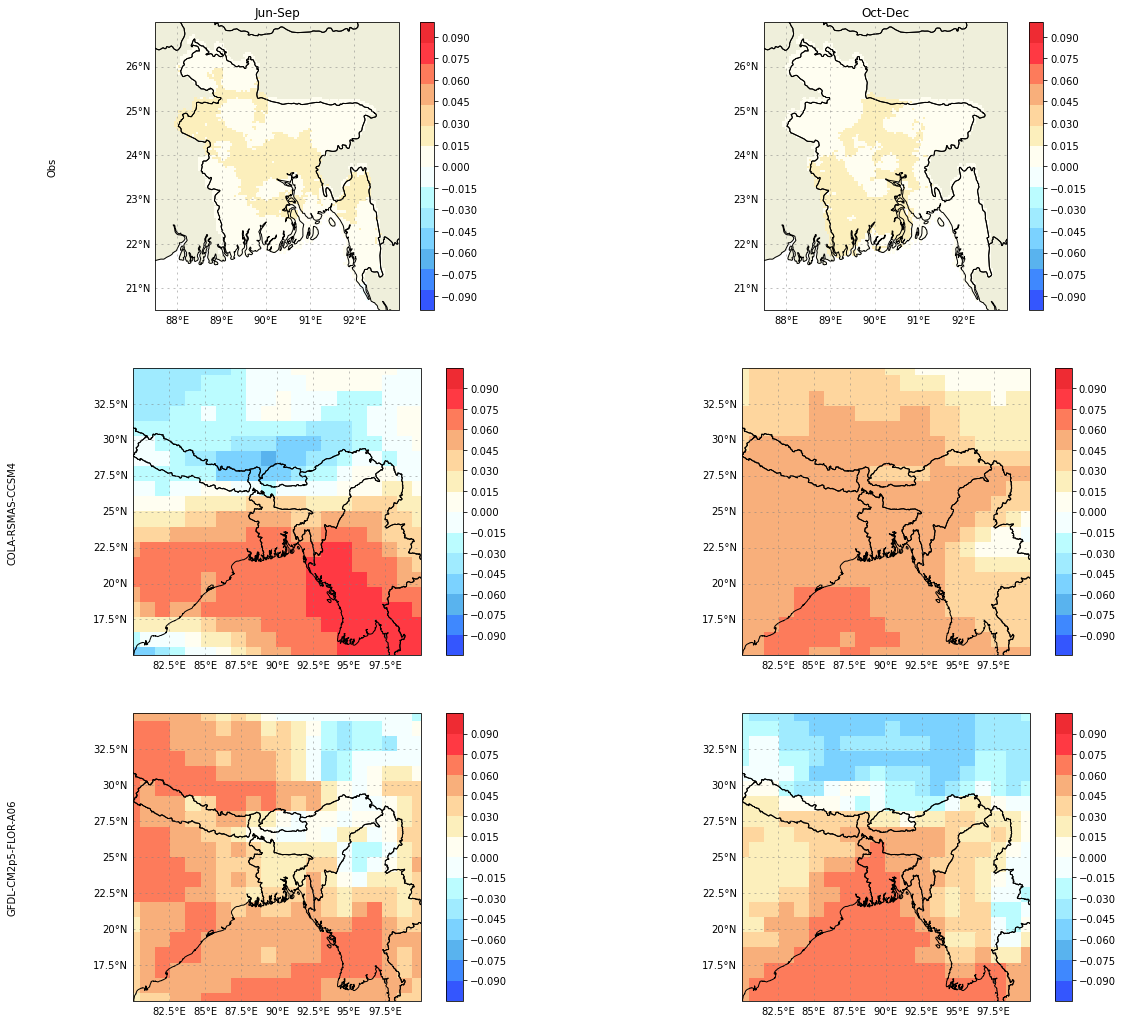




-------------EOF 2-------------



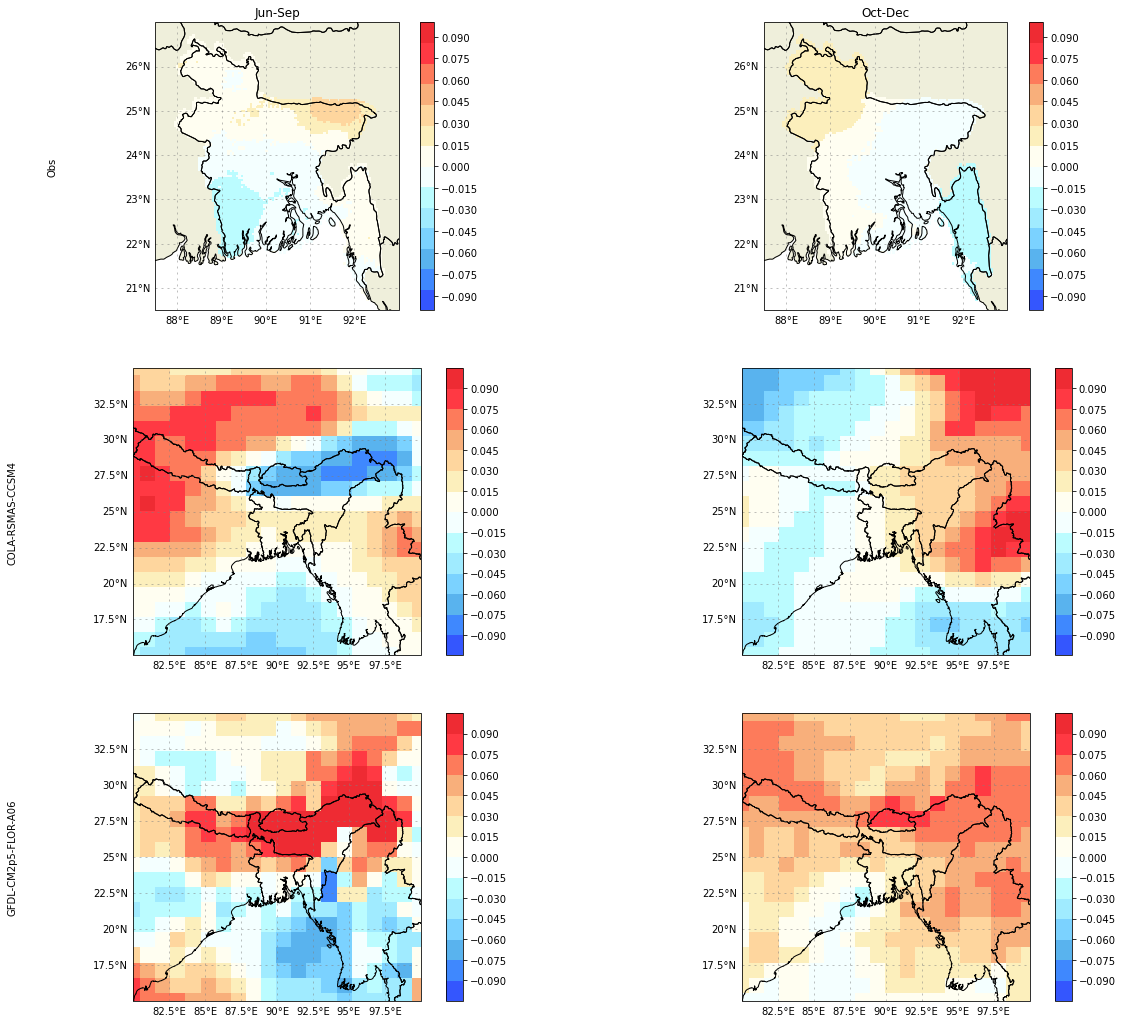




-------------EOF 3-------------



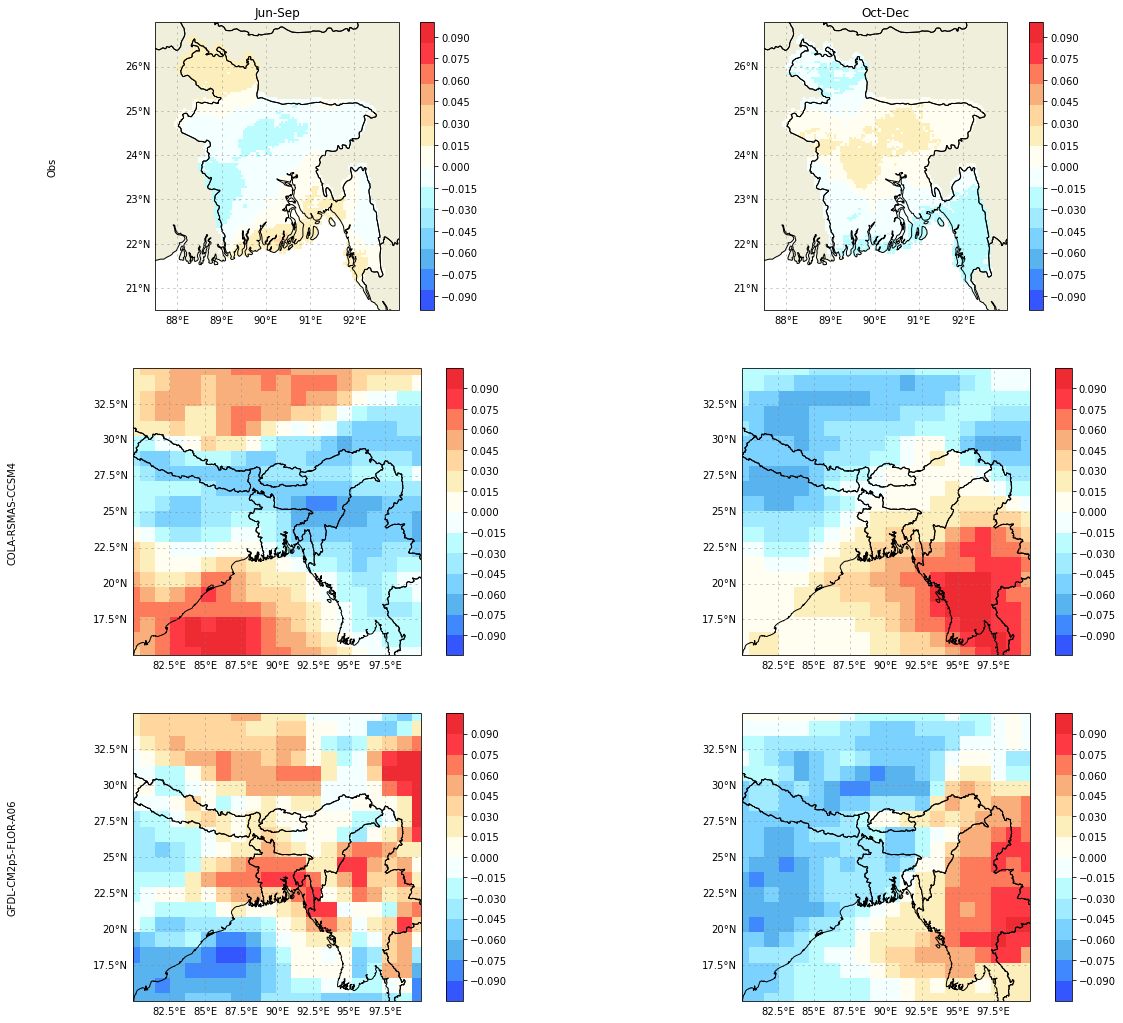

In [4]:
# Skill scores loop
if MOS in ['PCR', 'CCA']:
    for imod in range(eofmodes):
        pycpt.plteofs(imod)  

## Multi-model ensemble: NextGen

In [7]:
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']
pycpt.setNextGenModels(models)


for tgt in range(len(tgts)):

    #prepare files for nextgen input using simple mean
    pycpt.NGensemble(tgt)

    #write CPT input script for NextGen
    pycpt.CPTscript(tgt)

    #run CPT for nextgen
    pycpt.run(tgt)

Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization May...
Cross-validated prediction files successfully produced
Executing CPT for NextGen and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...
Cross-validated prediction files successfully produced
Executing CPT for NextGen and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Oct-Dec_Sep.txt for errors
----------------------------------------------
----


Pearson
failed to add your shape file
failed to add your shape file


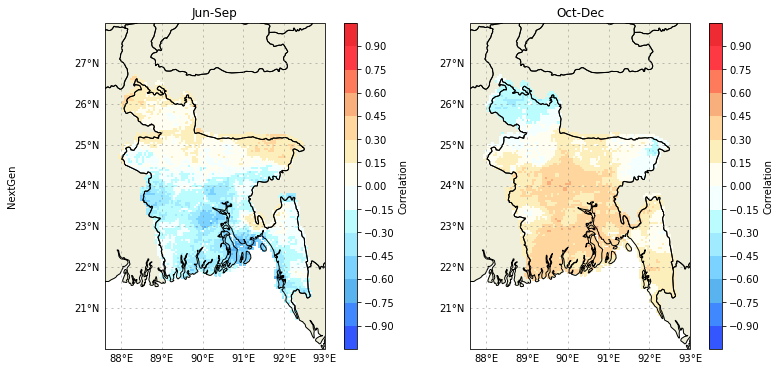


Spearman
failed to add your shape file
failed to add your shape file


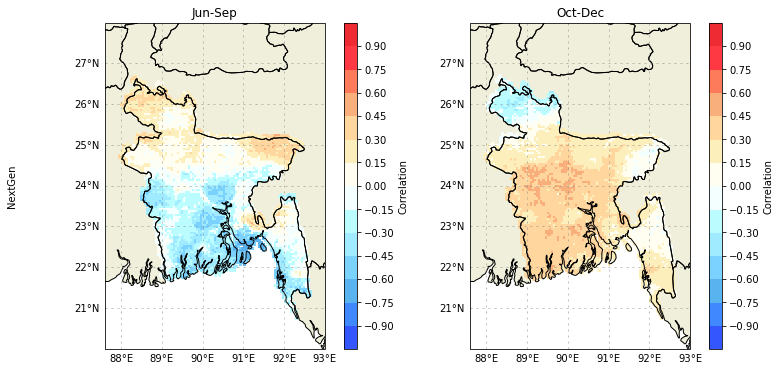


2AFC
failed to add your shape file
failed to add your shape file


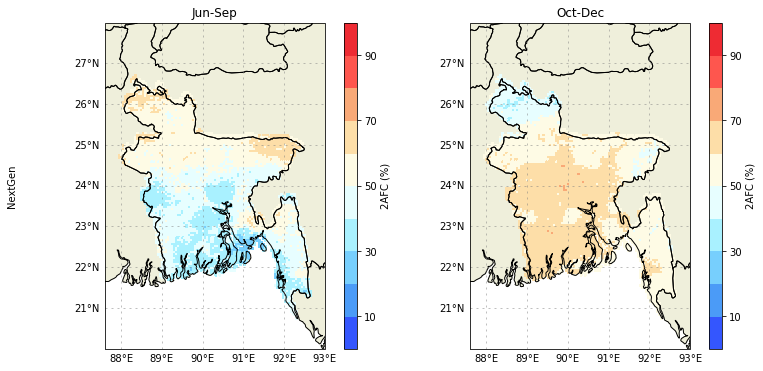


RocAbove
failed to add your shape file
failed to add your shape file


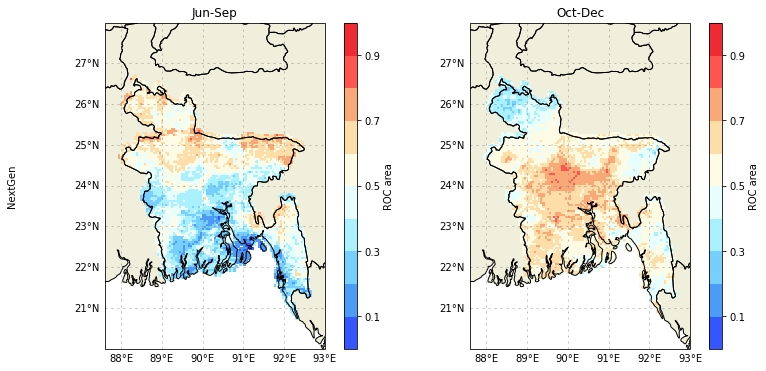


RocBelow
failed to add your shape file
failed to add your shape file


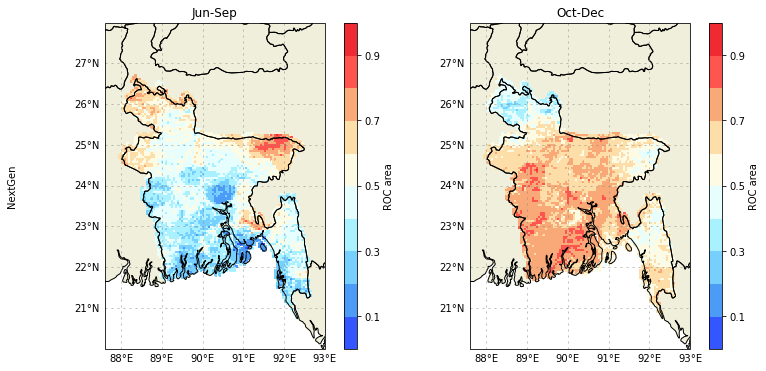


RMSE
failed to add your shape file
failed to add your shape file


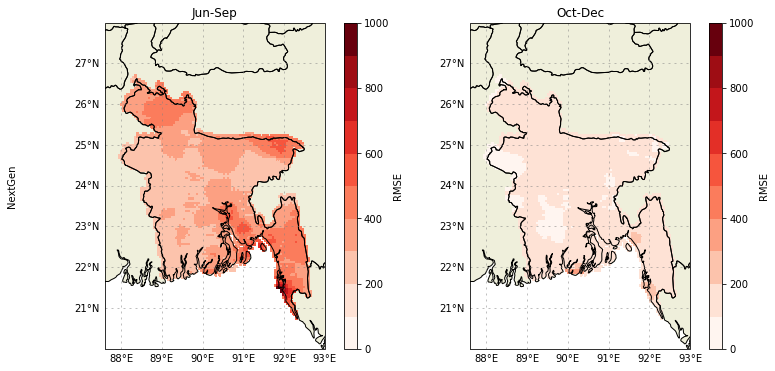

In [8]:
# Skill scores loop
for ime in range(len(met)):
    pycpt.pltmap(ime, isNextGen=1)   

# Real-Time Forecast

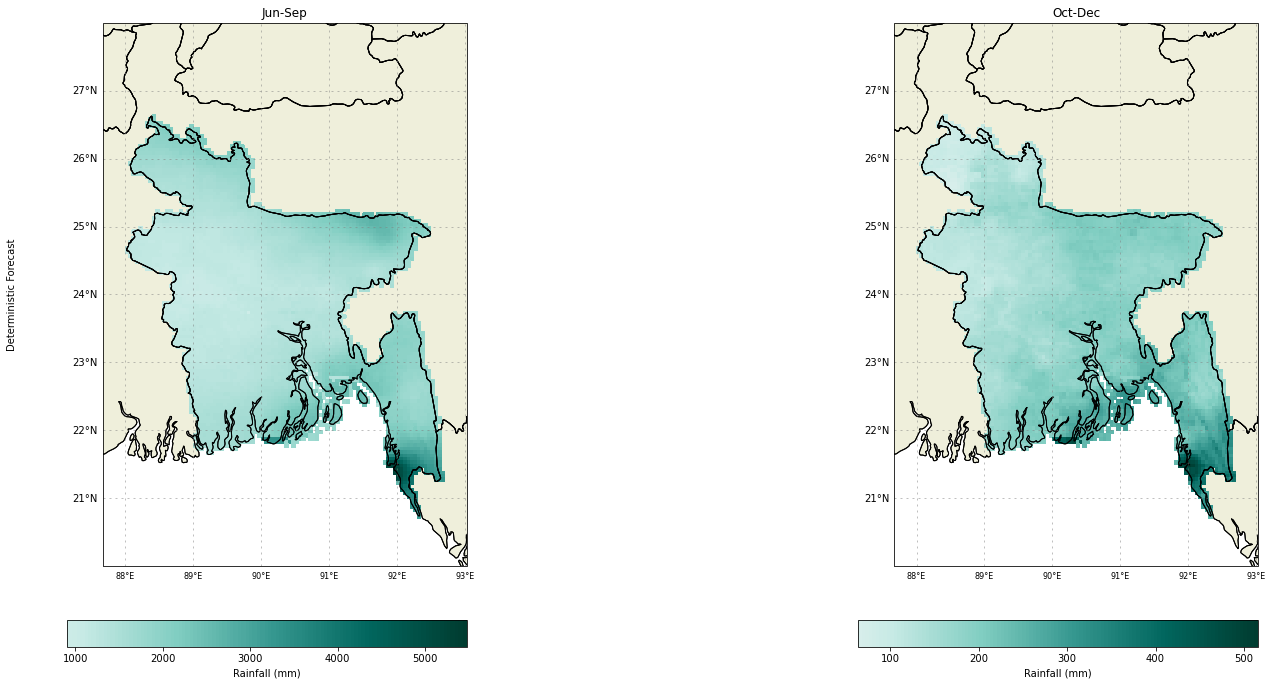

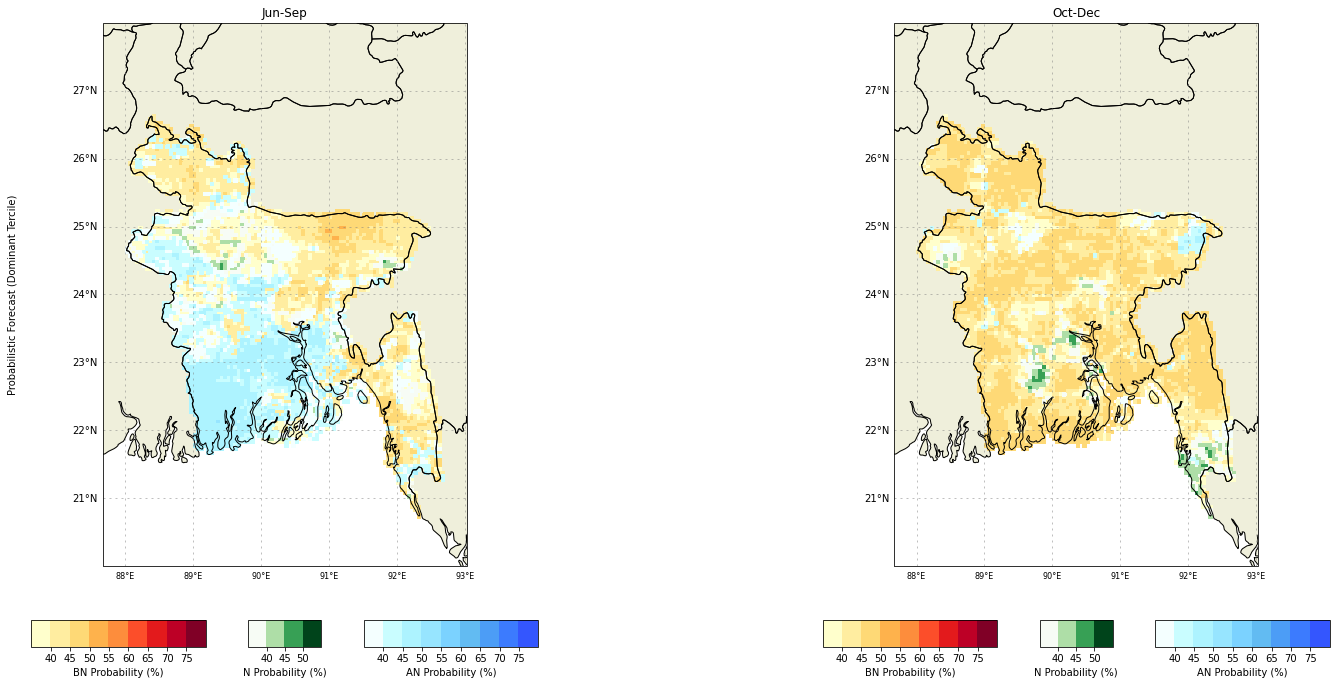

In [9]:
pycpt.plt_ng_deterministic()
pycpt.plt_ng_probabilistic()

In [10]:
models = ['NextGen']
pycpt.setNextGenModels(models)
pycpt.ensemblefiles(['NextGen'],work)

a 0.txt
a 10.txt
a 131.txt
a 1982.txt
a 20.txt
a 455.txt
a 501.txt
a NextGen_PRCP_CCAFCST_Obs_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_Obs_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_P_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_P_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_mu_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_mu_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_var_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_var_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_xvPr_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_xvPr_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCAFCST_z_Jun-Sep_May2019.txt
a NextGen_PRCP_CCAFCST_z_Oct-Dec_Sep2019.txt
a NextGen_PRCP_CCA_2AFC_Jun-Sep_May2019.txt
a NextGen_PRCP_CCA_2AFC_Oct-Dec_Sep2019.txt
a NextGen_RFCST_PRCP_Jun-Sep_iniMay2019.txt
a NextGen_RFCST_PRCP_Oct-Dec_iniSep2019.txt
a Y.txt
tar cvzf ./output/NextGen/Final_Test3_NextGen.tgz *.txt
/Users/kylehall/Projects/PYCPT/Test/PyCPT-Dev/Final_Test3
Compressed file Final_Test3_NextGen.tgz created in output/NextGen/
Now send tha